In [ ]:
import tools21cm as t2c
import numpy as np, matplotlib.pyplot as plt, os, pickle
from tqdm import tqdm

import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm, Normalize

In [ ]:
def plot_LC(img, i_z):
    fig = plt.figure(figsize=(28, 18))
    gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[3,1], height_ratios=[1, 1, 1])
    ax0 = fig.add_subplot(gs[0,0])
    im = ax0.imshow(img[:,64,:], cmap='jet', aspect='auto', origin='lower')
    fig.colorbar(im, ax=ax0, pad=0.01, fraction=0.048)
    ax01 = fig.add_subplot(gs[0,1])
    #ax01.set_title(r'z=%.3f    $\nu_{obs}$ = %d MHz' %(redshift[i_z], t2c.z_to_nu(z)), fontsize=18)
    ax01.imshow(img[:,:,i_z], cmap='jet', origin='lower')
    fig.colorbar(im, ax=ax01, pad=0.01, fraction=0.048) #, label=r'$\delta T_b$ [mk]')

In [6]:
path_in = '/store/ska/sk09/segunet/test_noise/'
path_out = '/scratch/snx3000/mibianco/test_segunet/'

with open('%sparameters/user_params.txt' %path_in,'r') as f:
    params = eval(f.read())
    
with open('%sparameters/cosm_params.txt' %path_in,'r') as f:
    cosmo_par = eval(f.read())

redshift = np.loadtxt(path_in+'lc_redshifts.txt')
dT = t2c.read_cbin(path_in+'data/dT_21cm_i0.bin')
xHI = t2c.read_cbin(path_in+'data/xHI_21cm_i0.bin')
print(dT.shape)

(128, 128, 552)


0.0 6.8039885 32.685238


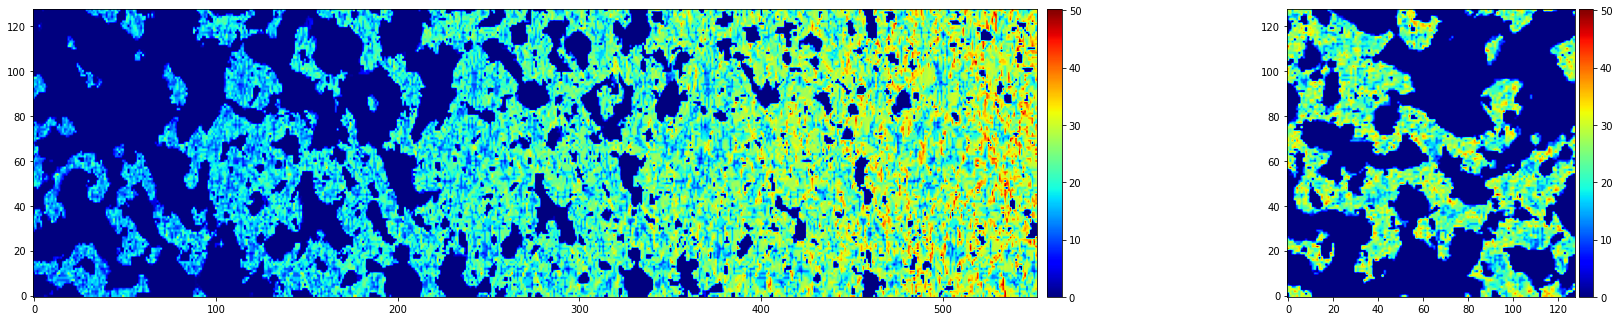

In [4]:
i = 100
plot_LC(dT, i)
print(dT[..., i].min(), dT[..., i].mean(), dT[..., i].max())

In [3]:
import numpy as np, os, pickle
import tools21cm as t2c
from tqdm import tqdm

path_out = '/scratch/snx3000/mibianco/test_uv/'
antconf = '/store/ska/sk09/segunet/SKA1_LowConfig_Sept2016_XYZ.txt'

params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':256}
redshift = np.arange(7.001, 11.001, 0.001)

# multiprocessor variables
#rank = int(os.environ['SLURM_ARRAY_TASK_ID'])
#nprocs = int(os.environ['SLURM_ARRAY_TASK_COUNT'])
rank, nprocs = 0, 1
loop_start, loop_end = 0, 300
perrank = (loop_end-loop_start)//nprocs

# loop index
resume_step = 0
i_start = int(loop_start+resume_step+rank*perrank)
if(rank != nprocs-1):
    i_end = int(loop_start+(rank+1)*perrank)
else:
    i_end = loop_end

for i in tqdm(range(i_start, i_end)):
    z = redshift[i]
    file_uv, file_Nant = '%s/uvmap_z%.3f.npy' %(path_out, z), '%s/Nantmap_z%.3f.npy' %(path_out, z)

    if not (os.path.exists(file_uv)):
        uv, Nant = t2c.get_uv_daily_observation(params['HII_DIM'], z, filename=antconf, total_int_time=6.0, int_time=10.0, boxsize=params['BOX_LEN'], declination=-26.82472208, verbose=False)
        np.save(file_uv, uv)

    if not (os.path.exists(file_Nant)):
        np.save(file_Nant, Nant)


  1%|          | 3/300 [02:24<3:58:57, 48.28s/it]

...done



  1%|          | 3/300 [02:38<4:21:52, 52.90s/it]


KeyboardInterrupt: 

Making uv map from daily observations.


100%|██████████| 2159/2159 [02:15<00:00, 15.89it/s]


...done


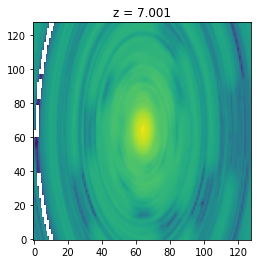

In [11]:
z = 7.001
#antconf = '/store/ska/sk09/segunet/SKA1_LowConfig_Sept2016_XYZ.txt'
antconf = '/store/ska/sk09/segunet/layout_rescaled.txt'
#uv, Nant = t2c.get_uv_daily_observation(params['HII_DIM'], z, filename=antconf, total_int_time=6.0, int_time=10.0, boxsize=params['BOX_LEN'], declination=-30.0, verbose=True)

uv, Nant = t2c.get_uv_daily_observation(128, z, filename=antconf, total_int_time=6.0, int_time=10.0, boxsize=256., declination=-30, verbose=True)
plt.title('z = %.3f' %z)
plt.imshow(np.log10(np.fft.fftshift(uv)), origin='lower')
plt.savefig(path_out+'new_uv.png', bbox_inches='tight', facecolor='white')

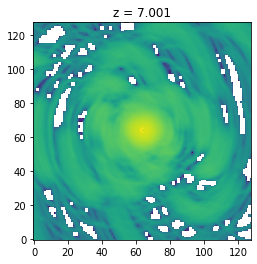

In [8]:
uvfile = '/store/ska/sk09/segunet/uvmap_128_z7-20.pkl'
uvdat = np.load(uvfile, allow_pickle=True)

plt.title('z = %.3f' %z)
plt.imshow(np.log10(np.fft.fftshift(uvdat['%.3f' %z])), origin='lower')
plt.savefig(path_out+'old_uv.png', bbox_inches='tight', facecolor='white')

In [6]:
tobs = 1000.
uvfile = '/store/ska/sk09/segunet/uvmap_128_z7-20.pkl'
antconf = '/store/ska/sk09/segunet/SKA1_LowConfig_Sept2016_XYZ.txt'

new_lc_noise = t2c.noise_lightcone(ncells=dT.shape[0], zs=redshift, filename=antconf, obs_time=tobs, save_uvmap=uvfile, boxsize=params['BOX_LEN'], n_jobs=1)
lc_noise = t2c.noise_lightcone(ncells=dT.shape[0], zs=redshift, obs_time=tobs, save_uvmap=uvfile, boxsize=params['BOX_LEN'], n_jobs=1)
#lc_noise = t2c.read_cbin(path_in+'data/noise_21cm_i0.bin')

dT2 = t2c.subtract_mean_signal(dT, los_axis=2)  
dT3, redshifts = t2c.smooth_lightcone(dT2+lc_noise, z_array=redshift, box_size_mpc=params['BOX_LEN']) 
#smt_xn, redshifts = t2c.smooth_lightcone(xHI, z_array=redshift, box_size_mpc=params['BOX_LEN']) 

All or some uv maps is read from the given file. Be sure that they were run with the same parameter values as provided now.
Creating the uv maps.

z = 7.000 | 0.18 % completed | Elapsed time: 0.00 mins

z = 7.005 | 0.36 % completed | Elapsed time: 0.00 mins

z = 7.011 | 0.54 % completed | Elapsed time: 0.00 mins

z = 7.016 | 0.72 % completed | Elapsed time: 0.00 mins

z = 7.021 | 0.91 % completed | Elapsed time: 0.00 mins

z = 7.027 | 1.09 % completed | Elapsed time: 0.00 mins

z = 7.032 | 1.27 % completed | Elapsed time: 0.00 mins

z = 7.038 | 1.45 % completed | Elapsed time: 0.00 mins

z = 7.043 | 1.63 % completed | Elapsed time: 0.00 mins

z = 7.048 | 1.81 % completed | Elapsed time: 0.00 mins

z = 7.054 | 1.99 % completed | Elapsed time: 0.00 mins

z = 7.059 | 2.17 % completed | Elapsed time: 0.00 mins

z = 7.065 | 2.36 % completed | Elapsed time: 0.00 mins

z = 7.070 | 2.54 % completed | Elapsed time: 0.00 mins

z = 7.075 | 2.72 % completed | Elapsed time: 0.00 mins

z = 7.081 | 2

100%|██████████| 552/552 [00:00<00:00, 922.94it/s]


-13518.390420413225 0.08601677799779578 13853.81550222484


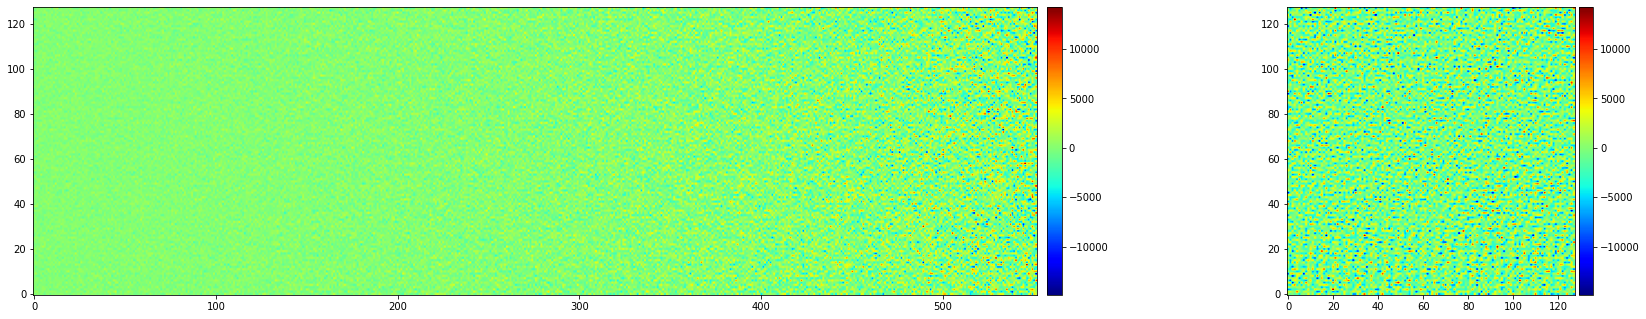

(None, None)

<Figure size 432x288 with 0 Axes>

In [7]:
i = 500
plot_LC(new_lc_noise, i)
print(new_lc_noise[..., i].min(), new_lc_noise[..., i].mean(), new_lc_noise[..., i].max())
plt.savefig(path_out+'new_dT3.png', bbox_inches='tight', facecolor='white')
#plt.savefig(path_out+'old_dT3.png', bbox_inches='tight', facecolor='white')
plt.show(), plt.clf()

-13518.390420413225 0.08601677799779578 13853.81550222484


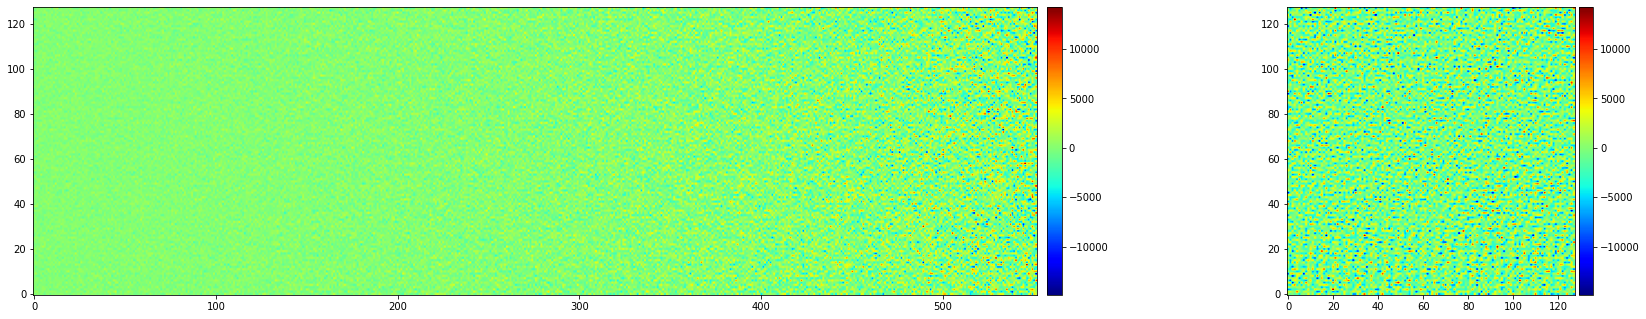

(None, None)

<Figure size 432x288 with 0 Axes>

In [8]:
i = 500
plot_LC(lc_noise, i)
print(lc_noise[..., i].min(), lc_noise[..., i].mean(), lc_noise[..., i].max())
plt.savefig(path_out+'old_dT3.png', bbox_inches='tight', facecolor='white')
plt.show(), plt.clf()

In [2]:
path_in = '/store/ska/sk09/test_PCA/'
path_out = '/scratch/snx3000/mibianco/test_segunet/'

ncells = 128
boxsize = 256

redshift = np.loadtxt(path_in+'lc_redshifts.txt')
dT = t2c.read_cbin(path_in+'dT_21cm_i0.bin')
print(dT.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/store/ska/sk09/test_PCA/dT_21cm_i0.bin'

In [3]:
np.random.seed(2022)

X  = np.random.normal(size=(ncells, ncells))
Y  = np.random.normal(size=(ncells, ncells))

dT_gf = np.zeros_like(dT)
dT_exgf = np.zeros_like(dT)
for i_z, z in tqdm(enumerate(redshift)):
    nu = t2c.z_to_nu(z)
    nu_s,A150,beta_,a_syn,Da_syn = 150,513,2.34,2.8,0.1
    U_cb  = (np.mgrid[-ncells/2:ncells/2,-ncells/2:ncells/2]+0.5)*t2c.z_to_cdist(z)/boxsize
    l_cb  = 2*np.pi*np.sqrt(U_cb[0,:,:]**2+U_cb[1,:,:]**2)
    C_syn = A150*(1000/l_cb)**beta_*(nu/nu_s)**(-2*a_syn-2*Da_syn*np.log(nu/nu_s))
    solid_angle = boxsize**2/t2c.z_to_cdist(z)**2
    AA = np.sqrt(solid_angle*C_syn/2)
    T_four = AA*(X+Y*1j)
    T_real = np.abs(np.fft.ifft2(T_four))   #in Jansky

    dT_gf[..., i_z] = t2c.jansky_2_kelvin(T_real*1e6, z, boxsize=boxsize, ncells=ncells)
    dT_exgf[..., i_z] = t2c.extragalactic_pointsource_fg(z=z, ncells=ncells, boxsize=boxsize, S_max=100)

#np.save(path_out+'dT_gf_i0', dT_gf)
#np.save(path_out+'dT_exgf_i0', dT_exgf)

#t2c.save_cbin(path_out+'dT_gf_i0.bin', data_gf)
#t2c.save_cbin(path_out+'dT_exgf_i0.bin', data_exgf)

552it [00:03, 174.05it/s]


In [4]:
dTsmt, _ = t2c.smooth_lightcone(lightcone=dT, z_array=redshift, box_size_mpc=256, max_baseline=2.0)
dTsmt_exgf, _ = t2c.smooth_lightcone(lightcone=dT_exgf, z_array=redshift, box_size_mpc=256, max_baseline=2.0)
dTsmt_gf, _ = t2c.smooth_lightcone(lightcone=dT_gf, z_array=redshift, box_size_mpc=256, max_baseline=2.0)

np.save(path_out+'dTsmt_21cm_i0.npy', dTsmt)
np.save(path_out+'dTsmt_exgf_i0.npy', dTsmt_exgf)
np.save(path_out+'dTsmt_gf_i0.npy', dTsmt_gf)

100%|██████████| 552/552 [00:00<00:00, 987.79it/s] 


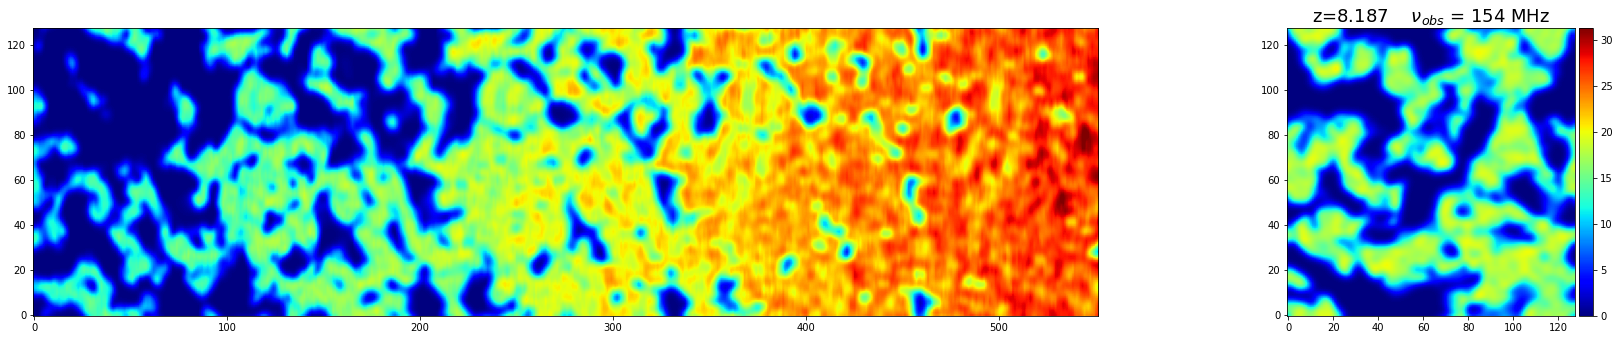

<Figure size 432x288 with 0 Axes>

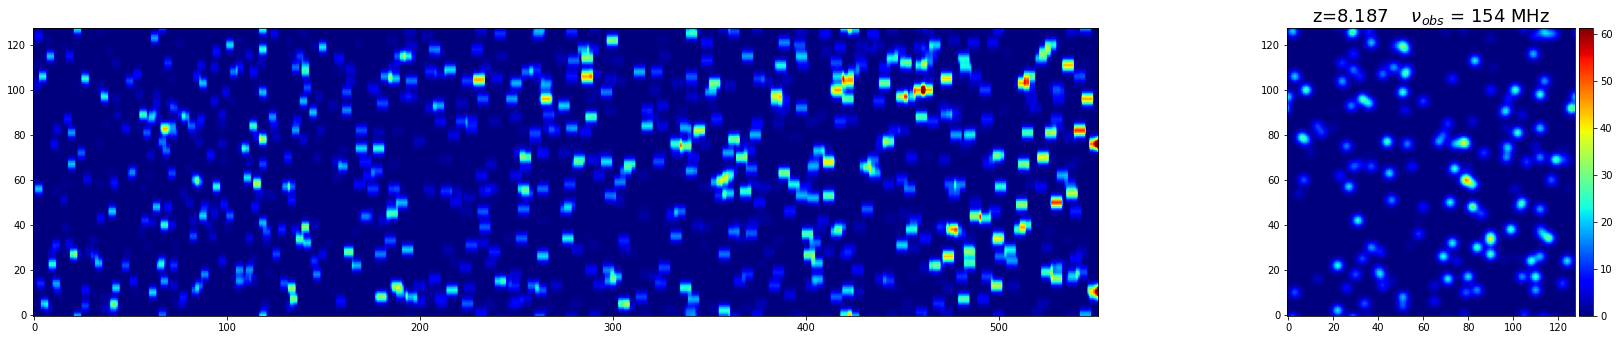

<Figure size 432x288 with 0 Axes>

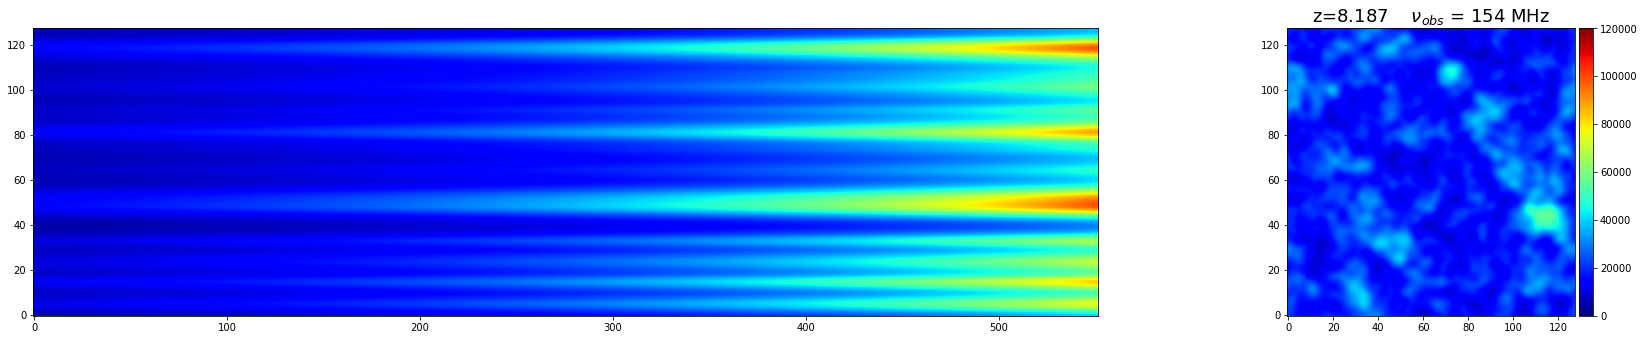

(None, None)

<Figure size 432x288 with 0 Axes>

In [5]:
i_z = 200
z = redshift[i_z]

def plot_LC(img):
    fig = plt.figure(figsize=(28, 18))
    gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[3,1], height_ratios=[1, 1, 1])
    ax0 = fig.add_subplot(gs[0,0])
    im = ax0.imshow(img[:,64,:], cmap='jet', aspect='auto', origin='lower', vmin=0, vmax=img[:,125,:].max())
    ax01 = fig.add_subplot(gs[0,1])
    ax01.set_title(r'z=%.3f    $\nu_{obs}$ = %d MHz' %(redshift[i_z], t2c.z_to_nu(z)), fontsize=18)
    ax01.imshow(img[:,:,i_z], cmap='jet', origin='lower', vmin=0, vmax=img[:,125,:].max())
    fig.colorbar(im, ax=ax01, pad=0.01, fraction=0.048)
    
plot_LC(dTsmt)
plt.savefig(path_out+'lc_21cm.png', bbox_inches='tight', facecolor='white')
plt.show(), plt.clf()

plot_LC(dTsmt_exgf)
plt.savefig(path_out+'lc_exgf.png', bbox_inches='tight', facecolor='white')
plt.show(), plt.clf()

plot_LC(dTsmt_gf)
plt.savefig(path_out+'lc_gf.png', bbox_inches='tight', facecolor='white')
plt.show(), plt.clf()

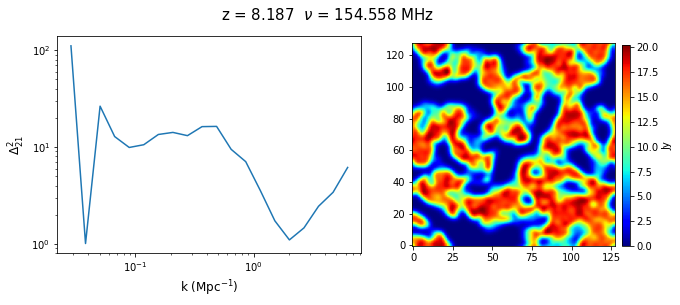

In [6]:
fig = plt.figure(figsize=(10, 4))
fig.suptitle(r'z = %.3f  $\nu$ = %.3f MHz' %(z, t2c.z_to_nu(z)), fontsize=15)
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.5, 1])
ax0 = fig.add_subplot(gs[0,0])
ps, ks, n_modes = t2c.power_spectrum_1d(dTsmt, kbins=20, box_dims=boxsize,return_n_modes=True, binning='log')
ax0.loglog(ks, ps*ks**3/2/np.pi**2, 'tab:blue', label=r'$T_S \gg T_{CMB}$')
ax0.set_xlabel('k (Mpc$^{-1}$)', fontsize=12), ax0.set_ylabel('$\Delta^2_\mathrm{21}$', fontsize=12)
ax1 = fig.add_subplot(gs[0,1])
im = ax1.imshow(dTsmt[...,i_z], origin='lower', cmap='jet')
#ax0.legend()
plt.colorbar(im, ax=ax1, cax=fig.add_axes([0.91, 0.15, 0.01, 0.7]), label='Jy')
plt.savefig(path_out+'test_21cm.png', bbox_inches='tight', facecolor='white')

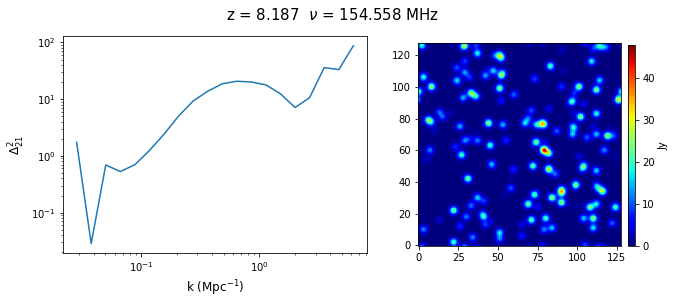

In [7]:
i_z = 200
z = redshift[i_z]

fig = plt.figure(figsize=(10, 4))
fig.suptitle(r'z = %.3f  $\nu$ = %.3f MHz' %(z, t2c.z_to_nu(z)), fontsize=15)
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.5, 1])
ax0 = fig.add_subplot(gs[0,0])
ps, ks, n_modes = t2c.power_spectrum_1d(dTsmt_exgf, kbins=20, box_dims=boxsize,return_n_modes=True, binning='log')
ax0.loglog(ks, ps*ks**3/2/np.pi**2, 'tab:blue', label=r'$T_S \gg T_{CMB}$')
ax0.set_xlabel('k (Mpc$^{-1}$)', fontsize=12), ax0.set_ylabel('$\Delta^2_\mathrm{21}$', fontsize=12)
ax1 = fig.add_subplot(gs[0,1])
im = ax1.imshow(dTsmt_exgf[...,i_z], origin='lower', cmap='jet')
#ax0.legend()
plt.colorbar(im, ax=ax1, cax=fig.add_axes([0.91, 0.15, 0.01, 0.7]), label='Jy')
plt.savefig(path_out+'test_gf.png', bbox_inches='tight', facecolor='white')

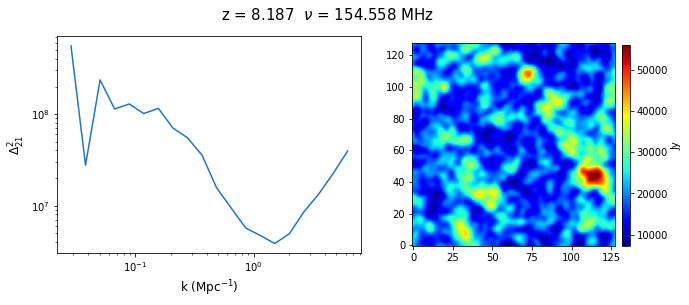

In [8]:
i_z = 200
z = redshift[i_z]

fig = plt.figure(figsize=(10, 4))
fig.suptitle(r'z = %.3f  $\nu$ = %.3f MHz' %(z, t2c.z_to_nu(z)), fontsize=15)
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.5, 1])
ax0 = fig.add_subplot(gs[0,0])
ps, ks, n_modes = t2c.power_spectrum_1d(dTsmt_gf, kbins=20, box_dims=boxsize,return_n_modes=True, binning='log')
ax0.loglog(ks, ps*ks**3/2/np.pi**2, 'tab:blue', label=r'$T_S \gg T_{CMB}$')
ax0.set_xlabel('k (Mpc$^{-1}$)', fontsize=12), ax0.set_ylabel('$\Delta^2_\mathrm{21}$', fontsize=12)
ax1 = fig.add_subplot(gs[0,1])
im = ax1.imshow(dTsmt_gf[...,i_z], origin='lower', cmap='jet')
#ax0.legend()
plt.colorbar(im, ax=ax1, cax=fig.add_axes([0.91, 0.15, 0.01, 0.7]), label='Jy')
plt.savefig(path_out+'test_exgf.png', bbox_inches='tight', facecolor='white')

In [13]:
antxyz.shape

(512, 3)

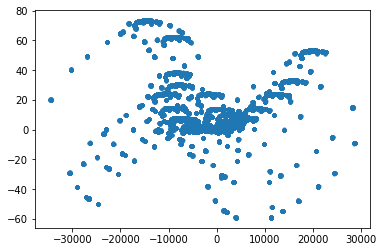

(None, None)

<Figure size 432x288 with 0 Axes>

In [11]:

new_antxyz = np.loadtxt('/project/c31/SKA_low_images/ska1low.tm/layout.txt')

new_Nbase = []
for ii,jj in list(pair_comb):
    ux = (new_antxyz[ii,0]-new_antxyz[jj,0])/lam
    uy = (new_antxyz[ii,1]-new_antxyz[jj,1])/lam
    uz = (new_antxyz[ii,2]-new_antxyz[jj,2])/lam
    if ux==0: print(ii,jj)
    new_Nbase.append([ux,uy,uz])
new_Nbase = np.array(new_Nbase)
plt.scatter(new_Nbase[:,1], new_Nbase[:,2], marker='.')
plt.show(), plt.clf()

In [13]:
new_Nbase.shape

(130816, 3)

(256, 256)


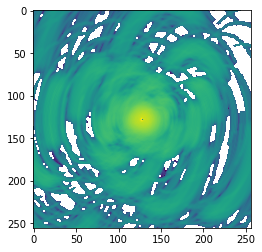

In [8]:
import numpy as np

path = '/scratch/snx3000/mibianco/test_uv/'

uvdata = np.load(path+'uvmap_z7.970.npy')

plt.imshow(np.log10(np.fft.fftshift(uvdata)))
print(uvdata.shape)

uvs = {}


In [11]:
import numpy as np, os, pickle

path_out = '/scratch/snx3000/mibianco/test_uv/'
redshift = np.arange(7.001, 12.001, 0.001)

uvs = {}
for z in tqdm(redshift):
    uv_map = np.load('%suvmap_z%.3f.npy' %(path_out, z))
    uvs['{:.3f}'.format(z)] = uv_map

uvs['Nant'] = np.load('%sNantmap.npy' %(path_out))
pickle.dump(uvs, open('%suvmap_128_z%d-%d.pkl' %(path_out, redshift.min(), redshift.max()), 'wb'))

os.system('rm %s*.npy' %path_out)
#print('rm %s*.npy' %path_out)

100%|██████████| 5000/5000 [00:04<00:00, 1065.98it/s]


0

In [13]:
uvdata = pickle.load(open('/scratch/snx3000/mibianco/test_uv/uvmap_128_z7-12.pkl', 'rb'))


In [27]:
redshift = np.arange(7.000, 30.005, 0.001)
round(redshift.max(),3)

30.004